# Week 3

## Tobit Regression

**References:**
- https://www.coursera.org/learn/guided-tour-machine-learning-finance/notebook/PmV1P/tobit-regression
- https://en.wikipedia.org/wiki/Tobit_model

\begin{equation}
    y_{i}
    =
    \begin{cases}
        y^{*}_{i}, & ~~~ y^{*}_{i} > 0 \\
        0, & ~~~ y^{*}_{i} <= 0
    \end{cases}
\end{equation}

where $y^{*}_{i}$ is the latent variable

\begin{equation}
    y^{*}_{i}
    =
    \beta x_{i} + u_{i}
\end{equation}

with $u_{i} ~ \mathcal{N}(0,\sigma^{2})$

\begin{equation}
    \mathcal{L}(y_{i})
    =
    \
\end{equation}

In [78]:
import numpy as np
import tensorflow as tf
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [59]:
class Tobit_Regression:
    
    def __init__(self, n_features, learning_rate=0.005, L=0):
        
        self.input  = tf.placeholder(tf.float32, [None, n_features], name="Input")
        self.target = tf.placeholder(tf.float32, [None, 1], name="Target")
        
        # the first weight is for the intercept, the last one is for a square root of the noise std 
        self.weights = tf.Variable(tf.random_normal([n_features + 2, 1]))
        
        # Augmented data matrix is obtained by adding a column of ones to the data matrix
        self.data_plus_bias = tf.concat([tf.ones([tf.shape(self.input)[0], 1]), self.input], axis=1)

        ###############################
        # MLE for Tobit regression 
        
        # noise volatility is obtained as a square of the last weight to ensure positivity 
        self.sigma = 0.0001 + tf.square(self.weights[-1])
        
        stdnormal = tf.distributions.Normal(loc=0.0, scale=1.0)
        
        y_pred = tf.matmul(self.data_plus_bias, self.weights[:-1])
        
        log_likelihood_term1 = tf.to_float(self.target > 0) * ( - tf.log(self.sigma)  + stdnormal.log_prob((self.target - y_pred)/self.sigma))
        log_likelihood_term2 = tf.to_float((self.target <= 0))*stdnormal.log_cdf(-y_pred/self.sigma)
        log_likelihood = log_likelihood_term1 + log_likelihood_term2
                                                    
        self.loss = -tf.reduce_mean(log_likelihood)
        
        #####################################################################

        # Use Adam optimization for training
        self.train_step = (tf.train.AdamOptimizer(learning_rate).minimize(self.loss), self.loss)
        
        # prediction made from the model: Use a ReLU neuron!
        self.output = tf.nn.relu(tf.matmul(self.data_plus_bias[:, :], self.weights[:-1]))
        
        # Check the output L1-norm error  
        self.output_L1_error = tf.reduce_mean(tf.abs(self.target - self.output))

    def generate_data(n_points,
                      n_features,
                      weights,
                      noise_std):

        # Bounds of [-1,1] in space of n_points x n_features
        np.random.seed(42)
        bias = np.ones(n_points).reshape((-1,1))
        low = - np.ones((n_points,n_features),'float')
        high = np.ones((n_points,n_features),'float')

        # simulated features are uniformally distributed on [-1,1].
        # The size n_points x n_features of array X is inferred by broadcasting of 'low' and 'high'
        X = np.random.uniform(low=low, high=high)
        
        # simulated noise
        noise = np.random.normal(size=(n_points, 1))
        
        # outputs    
        Y = weights[0] * bias + np.dot(X, weights[1:]).reshape((-1,1)) + noise_std * noise

        # truncate negative values of Y    
        np.clip(Y, a_min=0, a_max=None, out=Y)

        return X, Y    

In [60]:
def gen_tobit_dataset(n_points, n_features, train_test_split=4):
    """
    Generate dataset for Tobit regression model and split it into training and test portions
    
    """
    # n_features + 1 weights (one for a constant feature)
    data_weights = np.array([-0.25, 0.5, 0.2, .1]) 
    noise_std = 0.1
    
    # Generate dataset
    X, y = Tobit_Regression.generate_data(n_points=n_points,
                                           n_features=n_features,
                                           weights=data_weights,
                                           noise_std=noise_std)
    
    # split to the train and test set
    # 1/4 of the data is used for a test
    
    n_test = int(n_points / train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    y_train = y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    y_test = y[n_train:].reshape((-1,1))
    return X_train, y_train, X_test, y_test

### Generate dataset

In [73]:
n_points = 5000
n_features = 3

In [74]:
X_train, y_train, X_test, y_test = gen_tobit_dataset(n_points, n_features)

In [75]:
X_train.shape

(3750, 3)

In [76]:
y_train.shape

(3750, 1)

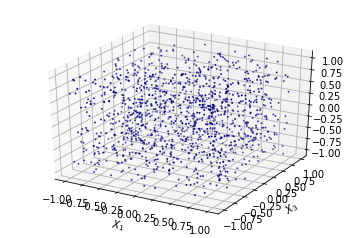

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_test[:,0], X_test[:,1], X_test[:,2], s=1, c="navy")
plt.xlabel('$X_{1}$')
plt.ylabel('$X_{2}$')
plt.ylabel('$X_{3}$')
plt.show()

### Model training

In [68]:
learning_rate = 0.05
n_steps = 1000

In [69]:
model = Tobit_Regression(n_features=n_features, learning_rate=learning_rate)

In [70]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    for _ in range(0, n_steps):
        (_, loss), weights = sess.run((model.train_step, model.weights), feed_dict={
            model.input: X_train,
            model.target: y_train
            })

    # predictions for the test set
    # std_model = weights[-1]**2     
    output, std_model = sess.run([model.output,model.sigma], 
                                 feed_dict={model.input: X_test})

    output_L1_error = sess.run(model.output_L1_error,
                               feed_dict={model.input: X_test,
                               model.target: y_test})
    sess.close()

## Linear regression with `sklearn`

In [81]:
def generate_data(n_points=10000, n_features=3, use_nonlinear=True, 
                    noise_std=0.1, train_test_split = 4):
    """
    Arguments:
    n_points - number of data points to generate
    n_features - a positive integer - number of features
    use_nonlinear - if True, generate non-linear data
    train_test_split - an integer - what portion of data to use for testing
    
    Return:
    X_train, Y_train, X_test, Y_test, n_train, n_features
    """
    # Linear data or non-linear data?
    if use_nonlinear:
        weights = np.array([[1.0, 0.5, 0.2],[0.5, 0.3, 0.15]], dtype=np.float32)
    else:
        weights = np.array([1.0, 0.5, 0.2], dtype=np.float32)
    
    np.random.seed(42)
    bias = np.ones(n_points).reshape((-1,1))
    low = - np.ones((n_points,n_features), dtype=np.float32)
    high = np.ones((n_points,n_features), dtype=np.float32)
    
    X = np.random.uniform(low=low, high=high)
    noise = np.random.normal(size=(n_points, 1))
    noise_std = 0.1
    
    if use_nonlinear:
        Y = (weights[0,0] * bias + np.dot(X, weights[0, :]).reshape((-1,1)) + 
             np.dot(X*X, weights[1, :]).reshape([-1,1]) +
             noise_std * noise)
    else:
        Y = (weights[0] * bias + np.dot(X, weights[:]).reshape((-1,1)) + 
             noise_std * noise)
    
    n_test = int(n_points/train_test_split)
    n_train = n_points - n_test
    
    X_train = X[:n_train,:]
    Y_train = Y[:n_train].reshape((-1,1))

    X_test = X[n_train:,:]
    Y_test = Y[n_train:].reshape((-1,1))
    
    return X_train, Y_train, X_test, Y_test, n_train, n_features

In [82]:
np.random.seed(42)
X_train, Y_train, X_test, Y_test, n_train, n_features = generate_data(use_nonlinear=True)
X_train.shape, Y_train.shape

((7500, 3), (7500, 1))

In [84]:
lr = LinearRegression()

In [85]:
lr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [87]:
lr.coef_

array([[1.00221739, 0.50122384, 0.19928303]])

In [86]:
lr.intercept_

array([1.31552735])

In [88]:
np.c_[lr.intercept_, lr.coef_]

array([[1.31552735, 1.00221739, 0.50122384, 0.19928303]])

\begin{equation}
    R^{2}
    =
    1
    -
    \frac{\sum_{i} (y_{t,i} - y_{pred,i})^{2} }
    {\sum_{i} (y_{t,i} - \bar{y_{t}})^{2}}
\end{equation}

In [89]:
lr.score(X_test, Y_test)

0.9065452090081394

## Neural network with `TensorFlow`

In [90]:
def random_batch(X_train, y_train, batch_size):
    
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    
    return X_batch, y_batch

In [92]:
def neuron_layer(X, n_neurons, name, activation_fn=None):
    
    with tf.name_scope(name):
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation_fn is not None:
            return activation_fn(Z)
        else:
            return Z

In [93]:
n_hidden1 = 100
n_hidden2 = 120
n_outputs = 1 # single value prediction
n_inputs = X_test.shape[1]

In [94]:
X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.float32, shape=(None), name="y")

In [95]:
layer_1 = neuron_layer(X, n_hidden1, "layer_1", tf.nn.relu)
layer_2 = neuron_layer(layer_1, n_hidden2, "layer_2", tf.nn.relu)
output  = neuron_layer(layer_2, n_outputs, "layer_output")
loss   = tf.reduce_mean(tf.square(output - y))

In [96]:
learning_rate = 0.01
n_epochs = 200
batch_size = 60
num_rec = X_train.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

In [97]:
train = tf.train.GradientDescentOptimizer(learning_rate).minimize(loss)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for i in range(n_epochs):
        X_batch, y_batch = random_batch(X_train, Y_train, batch_size)
        _, c = sess.run([loss, train], feed_dict={X: X_batch, y: y_batch})
    acc_test = sess.run(loss, feed_dict={X: X_test, y: Y_test})

In [98]:
acc_test

0.04375086